Automatic parameter estimation for GR4J. Uses scipy optimize packages.

Following exemples found in https://stackoverflow.com/questions/19664865/migrating-from-pulp-to-scipy

Preparing the functions

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as opt

# GR4J lives in a directory above this code. Not sure this is the best practice...
import os, sys
sys.path.append(os.path.relpath("../gr4j"))
from gr4j import gr4j

# discharge conversion functions
def m3_to_mm(q, area):
    '''Convert m3/s discharge data to mm/day
    q: list of daily discharge records
    area: basin area (km2)
    return: list of converted discharge records
    '''
    return [i * 86.4 / area for i in q]

## parameter transformation functions
# recieve a dictionary of parameters
# returns a dictionary of transformed (real) parameter

def real2transf(params):
    '''Convert real parameter to transformed'''
    x1 = np.log(params['X1'])
    x2 = np.arcsinh(params['X2'])
    x3 = np.log(params['X3'])
    x4 = np.log(params['X4']-0.5)
    return {'X1': x1,
            'X2': x2,
            'X3': x3,
            'X4': x4
           }

def transf2real(params):
    '''Convert transformed parameters to real'''
    x1 = np.exp(params['X1'])
    x2 = np.sinh(params['X2'])
    x3 = np.exp(params['X3'])
    x4 = np.exp(params['X4'])+0.5
    return {'X1': x1,
            'X2': x2,
            'X3': x3,
            'X4': x4
           }


# Objective function (Nash-Sutcliffe)
def nash(qobs, qsim):
    top = sum((qsim - qobs)**2)
    bottom = sum((qobs.mean() - qobs)**2)
    return 1 - top/bottom

# function to be minimized, using real parameter values
def fun(guess, prec, etp, qobs):
    params = {'X1': guess[0],
              'X2': guess[1],
              'X3': guess[2],
              'X4': guess[3]
             }
       
    states = {'production_store': 0.60 * params['X1'],
              'routing_store': 0.70 * params['X3']
             }

    qsim = gr4j(prec, etp, params, states)
    n = nash(qobs, qsim)
    return -n

# function to be minimized, using transformed parameters values
def fun_transf(guess, prec, etp, qobs):
    transf_params = {'X1': guess[0],
              'X2': guess[1],
              'X3': guess[2],
              'X4': guess[3]
             }
    
    params = transf2real(transf_params)
    
    states = {'production_store': 0.60 * params['X1'],
              'routing_store': 0.70 * params['X3']
             }

    qsim = gr4j(prec, etp, params, states)
    n = nash(qobs, qsim)
    return -n


Testing the automatic parameter estimation using the dataset that comes with the GR4J_en.xlsx model spreadsheet. This data is from _Le Léguer à Belle-Isle-en-Terre_ watershed. The original model was obtained from https://webgr.irstea.fr/en/modeles/journalier-gr4j-2/fonctionnement_gr4j/.

A more detailed description of the dataset can be found on the dataset directory of this repository.


In [68]:
# Reading sample data that comes with the original model - french basin
test_data = pd.read_csv('datasets/gr4j_test_data.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data = test_data.set_index('Date')

# Initial guess of TRANSFORMED model parameters
# done as a list since it's what the optimization function expects.
# GR4J function recieves a dictionary of REAL model parameters
# functon takes care of parameter convertion
# guess based on median parameter value reported by Perrin et al (2003)
# in real and transformed parameter space
guess = [350, 0, 90, 1.7]
guess_transf = [5.9, 0, 4.5, 0.18] 

# Calibrating model with the first year of data
prec_cal = test_data['Precip (mm)'].loc[:'1991-12-31']
etp_cal = test_data['ETP (mm)'].loc[:'1991-12-31']
qobs_cal = test_data['Qobs (mm/day)'].loc[:'1991-12-31']
qsim_orig_cal = test_data['Qsim (mm/day)'].loc[:'1991-12-31']

# bounds based on 80% parameter estimates (from Perrin et al, 2003)
# in real and transformed space
bnds = ((100, 1200),
        (-5, 3),
        (20, 300),
        (1.1, 2.9)
       )

bnds_transf = ((4.5, 7),
               (-2.31, 1.81),
               (3, 5.7),
               (-0.51, 0.87)
              )

# running optimization using transformed or real parameter values
result = opt.minimize(fun, guess, method='SLSQP',
                      args=(prec_cal, etp_cal, qobs_cal), bounds=bnds)

result_transf = opt.minimize(fun_transf, guess_transf, method='SLSQP',
                             args=(prec_cal, etp_cal, qobs_cal), bounds=bnds_transf)

#result = opt.minimize(fun, guess, method='Nelder-Mead', args=(prec_cal, etp_cal, qobs_cal))

# Simulating using the optimized parameters (transformed values)
t_params = {'X1': result_transf['x'][0],
          'X2': result_transf['x'][1],
          'X3': result_transf['x'][2],
          'X4': result_transf['x'][3]
         }

params_t = transf2real(t_params)
states_t = {'production_store': 0.60 * params_t['X1'],
          'routing_store': 0.70 * params_t['X3']
         }

# Running for the entire period but verifying for the seccond year
prec = test_data['Precip (mm)']
etp = test_data['ETP (mm)']
qobs = test_data['Qobs (mm/day)']
qsim_orig = test_data['Qsim (mm/day)']

qsim_t = gr4j(prec, etp, params_t, states_t)
qsim_t = pd.DataFrame(qsim_t, columns = ['qsim_t_mod'], index = pd.date_range('1991-1-1', '1992-12-30'))

# Simulating using the optimized parameters (real values)
params_r = {'X1': result['x'][0],
          'X2': result['x'][1],
          'X3': result['x'][2],
          'X4': result['x'][3]
         }

states_r = {'production_store': 0.60 * params_r['X1'],
          'routing_store': 0.70 * params_r['X3']
         }

qsim_r = gr4j(prec, etp, params_r, states_r)
qsim_r = pd.DataFrame(qsim_r, columns = ['qsim_r_mod'], index = pd.date_range('1991-1-1', '1992-12-30'))

data = pd.concat([test_data, qsim_t, qsim_r], axis=1)

# checking the adjustment (Nash-Sutcliffe)
print("Nash coefficient from the spreadsheet: 0.919")
print("Nash coefficient obtained using transformed parameter optimization: {:.3f}".format(nash(
    data['Qobs (mm/day)'].loc['1992-1-1':],
    data['qsim_t_mod'].loc['1992-1-1':])))
print("Nash coefficient obtained using real parameter optimization: {:.3f}".format(nash(
    data['Qobs (mm/day)'].loc['1992-1-1':],
    data['qsim_r_mod'].loc['1992-1-1':])))

Nash coefficient from the spreadsheet: 0.919
Nash coefficient obtained using transformed parameter optimization: 0.528
Nash coefficient obtained using real parameter optimization: 0.764


In [71]:
print('Model parameters in the spreadsheet were:')
print('X1: 320.107; X2: 2.421; X3: 69.628; X4: 1.389')
print('Model parameters obtained here (transformed optimization) are:')
print('X1: {:.3f}; X2: {:.3f}; X3: {:.3f}; X4: {:.3f}'
     .format(params_t['X1'], params_t['X2'],
             params_t['X3'], params_t['X4']))
print('Model parameters obtained here (real optimization) are:')
print('X1: {:.3f}; X2: {:.3f}; X3: {:.3f}; X4: {:.3f}'
     .format(params_r['X1'], params_r['X2'],
             params_r['X3'], params_r['X4']))

Model parameters in the spreadsheet were:
X1: 320.107; X2: 2.421; X3: 69.628; X4: 1.389
Model parameters obtained here (transformed optimization) are:
X1: 1096.633; X2: 1.435; X3: 82.399; X4: 1.100
Model parameters obtained here (real optimization) are:
X1: 379.965; X2: 1.714; X3: 138.283; X4: 1.100


In [56]:
# running the model with the parameters from the excell spreadsheet exemple
params_ex = {'X1': 320.107,
          'X2': 2.421,
          'X3': 69.628,
          'X4': 1.389
         }

states_ex = {'production_store': 0.60 * params['X1'],
          'routing_store': 0.70 * params['X3']
         }

qsim_ex = gr4j(prec, etp, params_ex, states_ex)

print('Running the model with the original parameters')
print('Nash coefficient equals to the one from the spreadsheet')
print('Nash: {:.3f}'.format(nash(
    data['Qobs (mm/day)'].loc['1992-1-1':],
    qsim_ex[365:])))

Running the model with the original parameters
Nash coefficient equals to the one from the spreadsheet
Nash: 0.919


What we've seen is that the python optimization can find some good parameters for the model. However, parameters obtained using the solver routines from excell yielded better results. Some things to evaluate:
1. What optimization algorithm does Excell solver utilizes?
  * For nonlinear optimization: Generalized Reduced Gradient (GRG2)
  * Linear programming: Simplex and dual Simplex from Simplex LP
  * non-smooth optimization: various genetic algorithms
  * source: https://www.solver.com/excel-solver-algorithms-and-methods-used
2. The excell spreadsheed optimizes a transformed coefficient. Check if that changes something
  * The documentation in the R package about adding other optimization methods mentions that we should used transformed parameters, to ensure homogenity of displacement in different dimensions of the parameter space
  * https://cran.r-project.org/web/packages/airGR/vignettes/V02.1_param_optim.html
3. Change options in the python solver
4. Deppending on the solver and on the initial guess, the optimizatin does not work and I get a "IndexError: list index out of range". Ex.: guess = [400, 3, 50, 2]; solver = SLSQP

Some observations with solver = SLSQP:

| Guess parameters   | Nash |
|--------------------|------|
| [303, 3.2, 65, 1]  | 0.768|
| [303, 3.2, 50, 0.5]| 0.728| 
|[320, 2.4, 70, 1.4] | 0.766|
|[320.11, 2.42, 69.63, 1.39]| 0.766|

Even using the initial guess very close to the results from the Excell spreadsheet, I cannot get a Nash coefficient close to 0.92! Need to investigate solver options a bit more.

Anyway, plotting some figures:


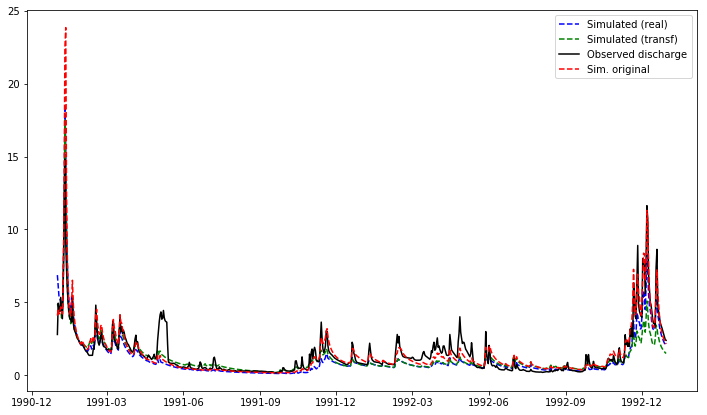

In [72]:
plt.figure(figsize=(12,7))

plt.plot(data['qsim_r_mod'], 'b--', label = 'Simulated (real)')
plt.plot(data['qsim_t_mod'], 'g--', label = 'Simulated (transf)')
plt.plot(data['Qobs (mm/day)'], 'k', label = 'Observed discharge')
plt.plot(data['Qsim (mm/day)'], 'r--', label = 'Sim. original')
plt.legend()

plt.show()

In [52]:
params = {'X1': 1200,
          'X2': 3,
          'X3': 300,
          'X4': 2.9
         }
real2transf(params)

{'X1': 7.0900768357760917,
 'X2': 1.8184464592320668,
 'X3': 5.7037824746562009,
 'X4': 0.87546873735389985}